# Ball Detection Analysis Notebook

This notebook processes ball detection data from the tennis game rally, performs data interpolation, calculates rolling means, and identifies significant changes to infer ball hits.


##### Importing necessary libraries

In [40]:
import pickle  # For loading serialized data
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For plotting data
import numpy as np # for math functions

##### Loading data from a pickle file containing ball detections

In [41]:
# Reading the pickle file containing ball positions.

with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

##### Preprocess Data

Extract ball positions and convert them into a pandas DataFrame. Then, interpolate missing values.

In [42]:
ball_positions = [x.get(1,[]) for x in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

##### Calculate Rolling Mean of Midpoint Y Coordinate

Compute the mid-point on the Y-axis and its rolling mean to smooth out the data.



In [43]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

##### Plot Rolling Mean of Y Midpoint

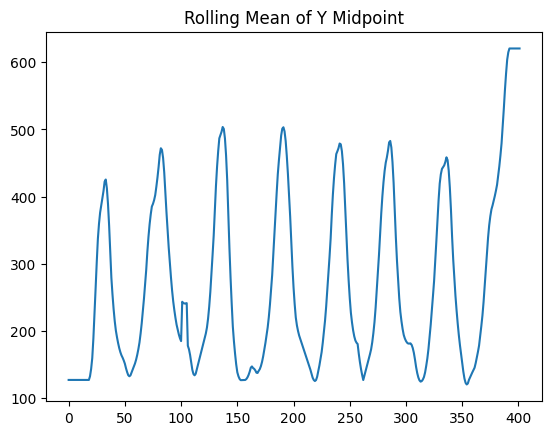

In [44]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])
plt.title('Rolling Mean of Y Midpoint')
plt.show()

##### Plot Delta of Y Midpoint Rolling Mean

Determine the difference between consecutive points of the rolling mean to detect changes.

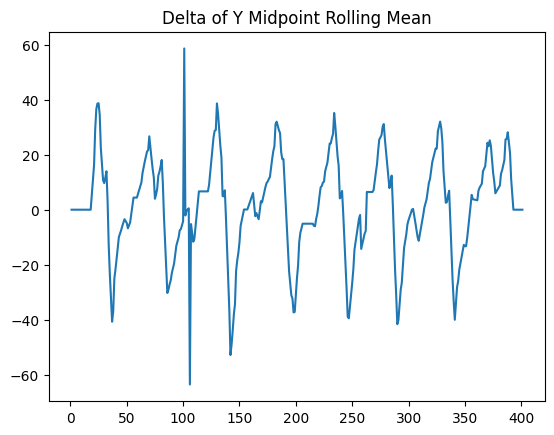

In [45]:

df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

# plot mid_y_rolling_mean
plt.plot(df_ball_positions['delta_y'])
plt.title('Delta of Y Midpoint Rolling Mean')
plt.show()

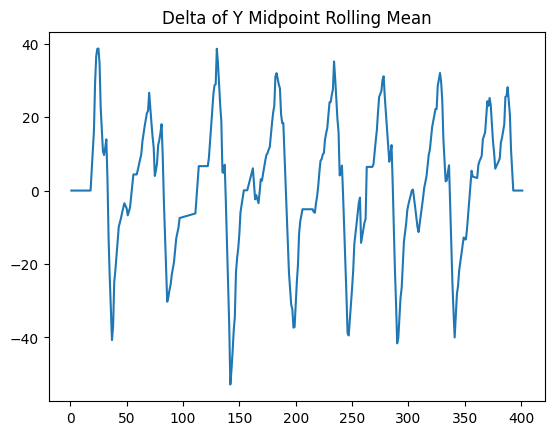

In [59]:
# Assuming df_ball_positions['mid_y_rolling_mean'] is already calculated
# Calculate delta_y as the difference of the rolling mean
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

# Set indices 98 to 109 to NaN
df_ball_positions.loc[98:110, 'delta_y'] = np.nan

# Interpolate the missing values linearly
df_ball_positions['delta_y'] = df_ball_positions['delta_y'].interpolate(method='linear')

plt.plot(df_ball_positions['delta_y'])
plt.title('Delta of Y Midpoint Rolling Mean')
plt.show()



##### Detect Ball Hits

Analyze delta changes to identify potential ball hits based on defined thresholds.

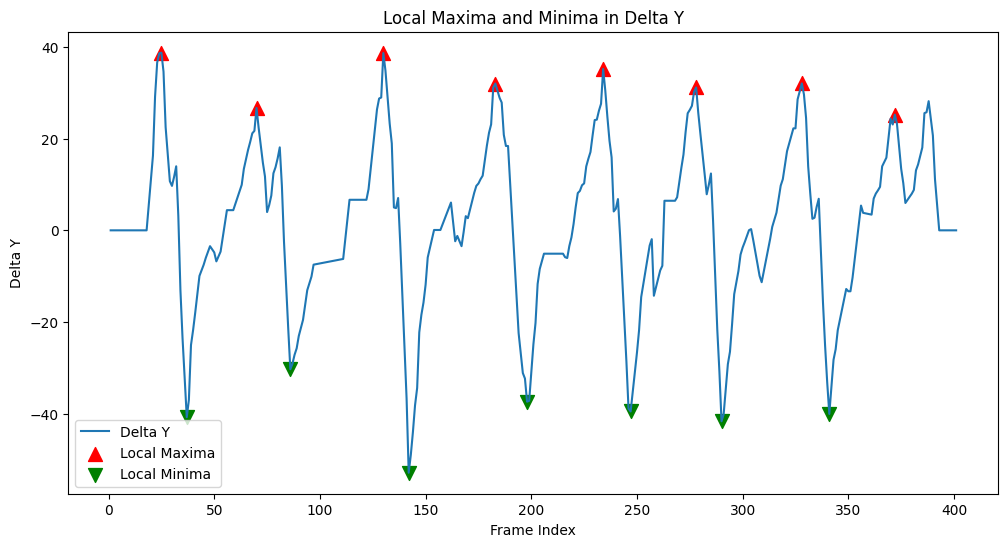

Local Maxima Indices: [25, 70, 130, 183, 234, 278, 328, 372]
Local Minima Indices: [37, 86, 142, 198, 247, 290, 341]


In [62]:
from scipy.signal import argrelextrema

# Assuming df_ball_positions and its 'delta_y' column are already defined
# Set the order parameter to define how many points on each side to use for the comparison to find extrema
order = 15  # Adjust this number based on your data's sampling frequency and characteristics

# Find local maxima
local_maxima = argrelextrema(df_ball_positions['delta_y'].values[:375], np.greater, order=order)[0]

# Find local minima
local_minima = argrelextrema(df_ball_positions['delta_y'].values[:375], np.less, order=order)[0]

# %%
# Plotting to visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df_ball_positions['delta_y'], label='Delta Y')
plt.scatter(local_maxima, df_ball_positions['delta_y'].iloc[local_maxima], color='r', label='Local Maxima', marker='^', s=100)
plt.scatter(local_minima, df_ball_positions['delta_y'].iloc[local_minima], color='g', label='Local Minima', marker='v', s=100)
plt.title('Local Maxima and Minima in Delta Y')
plt.xlabel('Frame Index')
plt.ylabel('Delta Y')
plt.legend()
plt.show()

# %%
# Print or use the indices of local maxima and minima
print("Local Maxima Indices:", local_maxima.tolist())
print("Local Minima Indices:", local_minima.tolist())


In [63]:
# Accessing DataFrame rows at these indices
print("Data at Local Maxima:")
print(df_ball_positions.iloc[local_maxima])

print("Data at Local Minima:")
print(df_ball_positions.iloc[local_minima])

Data at Local Maxima:
             x1          y1          x2          y2       mid_y  \
25   869.102478  365.462067  888.600403  384.260956  374.861511   
70   854.185059  372.007538  873.310059  391.775238  381.891388   
130  468.344482  468.453918  485.463074  486.403503  477.428711   
183  686.281250  409.296936  701.215088  425.277649  417.287292   
234  736.800781  448.904419  754.214355  466.223206  457.563812   
278  804.068176  431.832764  822.908752  449.958252  440.895508   
328  773.828857  424.189697  793.105957  444.591248  434.390472   
372  833.818237  357.950623  852.901123  378.989685  368.470154   

     mid_y_rolling_mean    delta_y  ball_hit  
25           302.447702  38.716959         0  
70           317.660590  26.677520         0  
130          380.560455  38.640588         0  
183          346.054692  31.996891         0  
234          372.607088  35.180306         0  
278          374.650098  31.149249         0  
328          365.114224  32.030176         0 

##### Conclusion

This notebook allows for the analysis of ball position data to detect significant events such as ball hits, which can be critical for further analysis or reporting.
